# White particles

I received a new image from Qiaoge, with the majority of particles white. See below:

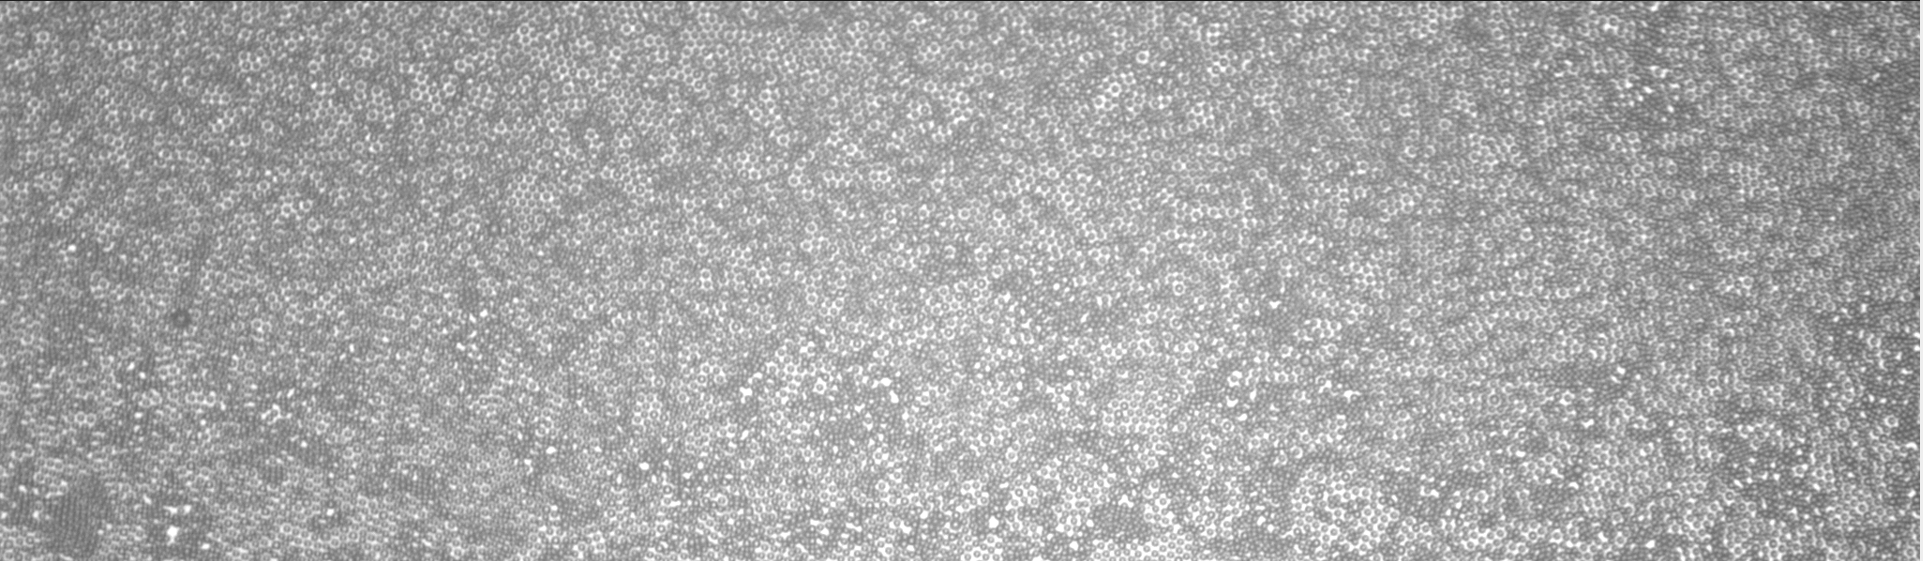

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from myimagelib.myImageLib import to8bit, matlab_style_gauss2D, bestcolor
from scipy.signal import convolve2d
from myimagelib.xcorr_funcs import normxcorr2, FastPeakFind
import pandas as pd
from skimage.feature import peak_local_max
from skimage import io, measure, draw
from bwtrack.bwtrack import *
from matplotlib.collections import PatchCollection

## 1 The old method

We can start by using the old `find_white()` function and see what is the problem. 

In [95]:
def find_white(img, size=7, thres=None, std_thres=None, plot_hist=False):
    """
    Similar to find_black.
    """
    
    img = to8bit(img) # convert to 8-bit and saturate
    
    mh = mexican_hat(shape=(5,5), sigma=0.8) # 这里shape和上面同理，sigma需要自行尝试一下，1左右
    #plt.imshow(mh, cmap="gray")

    corr = normxcorr2(mh, img, "same")
    coordinates = peak_local_max(corr, min_distance=5) 
    
    # apply min_dist criterion
    particles = pd.DataFrame({"x": coordinates.T[1], "y": coordinates.T[0]})
    # 加入corr map峰值，为后续去重合服务
    particles["peak"] = corr[particles.y, particles.x]
    particles = min_dist_criterion(particles, size)
    
    # 计算mask内的像素值的均值和标准差
    ## Create mask with feature regions as 1
    R = size / 2.
    mask = np.zeros(img.shape)
    for num, i in particles.iterrows():
        rr, cc = draw.disk((i.y, i.x), 0.8*R) # 0.8 to avoid overlap
        mask[rr, cc] = 1

    ## generate labeled image and construct regionprops
    label_img = measure.label(mask)
    regions = measure.regionprops_table(label_img, intensity_image=img, properties=("label", "centroid", "intensity_mean", "image_intensity")) # use raw image for computing properties
    table = pd.DataFrame(regions)
    table["stdev"] = table["image_intensity"].map(np.std)
    
    ## Arbitrary lower bound here, be careful!
    intensity_lb = (table["intensity_mean"].median() + table["intensity_mean"].mean()) / 4
    table = table.loc[table["intensity_mean"]>=intensity_lb]
    
    if thres is not None and std_thres is not None:
        table = table.loc[(table["intensity_mean"] <= thres)&(table["stdev"] <= std_thres)]
    elif thres is None and std_thres is None:
        print("Threshold value(s) are missing, all detected features are returned.")        
    elif thres is not None and std_thres is None:
        print("Standard deviation threshold is not set, only apply mean intensity threshold")
        table = table.loc[table["intensity_mean"] <= thres]
    elif thres is None and std_thres is not None:
        print("Mean intensity threshold is not set, only apply standard deviation threshold")
        table = table.loc[table["stdev"] <= std_thres]
    
    if plot_hist == True:
        table.hist(column=["intensity_mean", "stdev"], bins=20)
    
    table = table.rename(columns={"centroid-0": "y", "centroid-1": "x"}).drop(columns=["image_intensity"])

    return table

In [96]:
img = io.imread("large.tif")
particles = find_white(img, size=7)

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


In [14]:
particles

,label,y,x,intensity_mean,stdev
0,1,5.0,7.0,115.142857,45.822719
1,2,5.0,26.0,101.476190,38.996697
2,3,5.0,240.0,84.761905,34.328996
3,4,5.0,315.0,137.666667,53.905755
4,5,5.0,359.0,62.095238,23.977790
...,...,...,...,...,...
9910,9911,594.0,1904.0,82.952381,34.009081
9911,9912,594.0,1912.0,81.142857,32.451416
9912,9913,594.0,1936.0,109.095238,44.550089
9913,9914,594.0,1943.0,102.857143,42.108431


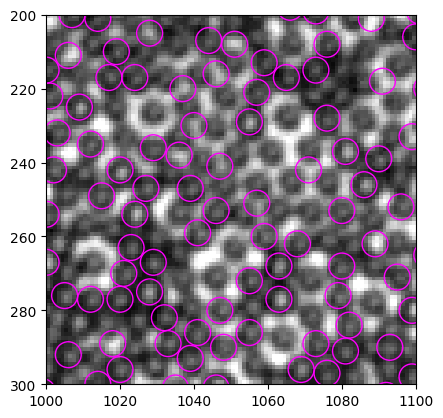

In [97]:
b_circ = [plt.Circle((xi, yi), radius=3.5, linewidth=1, fill=False, ec="magenta") for xi, yi in zip(particles.x, particles.y)]
b = PatchCollection(b_circ, match_original=True)
left, right, bottom, top = 1000, 1100, 300, 200
fig, ax = plt.subplots(dpi=100)
ax.imshow(img[top:bottom, left:right], cmap="gray", extent=(left, right, bottom, top))
ax.add_collection(b)

I have two general observations:
- only part of the particles are identified
- some bright "void" are identified as particles

These problems suggests that the mask we use to detect white particles - the Mexican hat shape - does not capture the characteristics of white particles well, and therefore leads to false positives and missing particles. We briefly discussed this issue before. Basically, Mexican hat shape describes an intensity profile that has a high peak in the center and a low ring in the intermediate distance, and a medium value in the long distance:

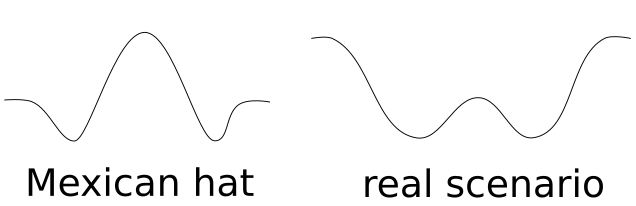

We can take a few example particles and study precisely the intensity profiles. (probably we can use a polynomial profile to fit)

## 2 A closer look at the white particle pixel intensity profiles

In this section, we crop out several representative white particles and closely examine their intensity profiles, to determine the mask to use to detect them. 

We choose particles from the four corners: 3115, 3197, 4155, 4014.

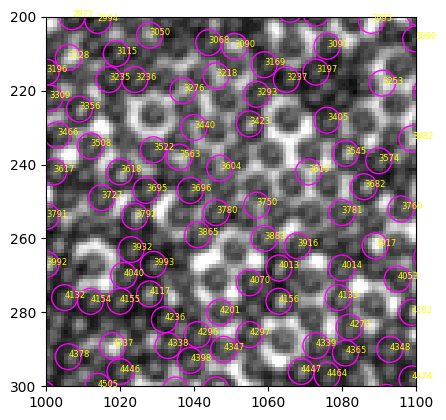

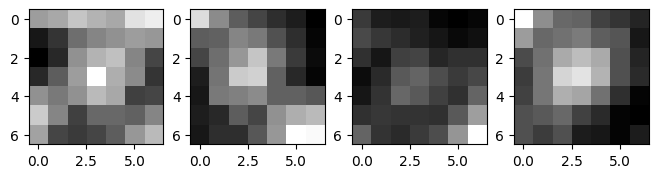

In [19]:
chosen = particles.query("label in [3115, 3197, 4155, 4014]")
size = 7

# show the cropped images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2))
crop = {}
for i in range(4):
    item = chosen.iloc[i]
    x = int(item.x)
    y = int(item.y)
    
    crop[i] = img[y-size//2: y-size//2 + size, x - size//2: x - size//2 + size]
    ax[i].imshow(crop[i], cmap="gray")

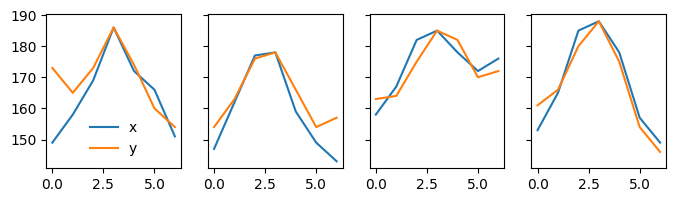

In [20]:
# plot all the x, y center line profiles
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2), sharey=True)
for i in range(4):
    ax[i].plot(crop[i][3, :], label="x")
    ax[i].plot(crop[i][:, 3], label="y")
    if i == 0:
        ax[i].legend(frameon=False)

When I choose size as 7 (px), most of these particle appear to be just a single peak, without the feature of dark ring and then bright background, the characteristic Mexican hat profile. This observation suggests that it might be bettet to simply use a gaussian mask to convolve the original image to detect white particles. 

## 3 A better mask?

It turns out that Mexican hat is not the optimal mask for detecting white particles. Actually, in the old `find_white` function, the default Mexican hat mask `mh` is not even the same size as the paricles. The old default mask is:

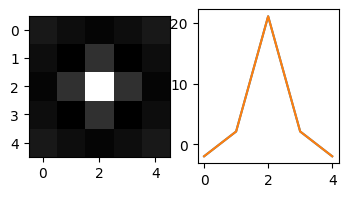

In [30]:
mh = mexican_hat(shape=(5,5), sigma=0.8)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
ax[0].imshow(mh, cmap="gray")
ax[1].plot(mh[2, :])
ax[1].plot(mh[:, 2])

### 3.1 Try different parameters of Mexican hat

This is not really a Mexican hat, because the shape (5, 5) has truncated the profile before the tails rise again at long distances from the center peak. The mask (5,5) being smaller than the feature (D=7) could lead to the problem that many particles are not identified (because in the original image, a particle may not show up as a peak in a (5,5) region). 

My intuition is, if I enlarge the size of the mask, while keeping the Mexican hat profile, I can get a better tracking. Let's try the following mask.

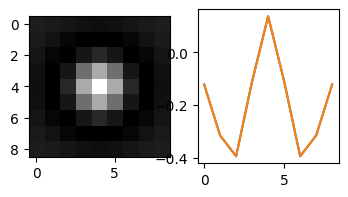

In [69]:
mh = mexican_hat(shape=(9,9), sigma=1.5)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
ax[0].imshow(mh, cmap="gray")
ax[1].plot(mh[2, :])
ax[1].plot(mh[:, 2])

In [70]:
def find_white(img, size=7, thres=None, std_thres=None, plot_hist=False):
    """
    Similar to find_black.
    """
    
    img = to8bit(img) # convert to 8-bit and saturate
    
    mh = mexican_hat(shape=(9,9), sigma=1.5) # 这里shape和上面同理，sigma需要自行尝试一下，1左右
    #plt.imshow(mh, cmap="gray")

    corr = normxcorr2(mh, img, "same")
    coordinates = peak_local_max(corr, min_distance=3) 
    
    # apply min_dist criterion
    particles = pd.DataFrame({"x": coordinates.T[1], "y": coordinates.T[0]})
    # 加入corr map峰值，为后续去重合服务
    particles["peak"] = corr[particles.y, particles.x]
    # particles = min_dist_criterion(particles, size)
    
    # 计算mask内的像素值的均值和标准差
    ## Create mask with feature regions as 1
    R = size / 2.
    mask = np.zeros(img.shape)
    for num, i in particles.iterrows():
        rr, cc = draw.disk((i.y, i.x), 0.8*R) # 0.8 to avoid overlap
        mask[rr, cc] = 1

    ## generate labeled image and construct regionprops
    label_img = measure.label(mask)
    regions = measure.regionprops_table(label_img, intensity_image=img, properties=("label", "centroid", "intensity_mean", "image_intensity")) # use raw image for computing properties
    table = pd.DataFrame(regions)
    table["stdev"] = table["image_intensity"].map(np.std)
    
    ## Arbitrary lower bound here, be careful!
    intensity_lb = (table["intensity_mean"].median() + table["intensity_mean"].mean()) / 4
    table = table.loc[table["intensity_mean"]>=intensity_lb]
    
    if thres is not None and std_thres is not None:
        table = table.loc[(table["intensity_mean"] <= thres)&(table["stdev"] <= std_thres)]
    elif thres is None and std_thres is None:
        print("Threshold value(s) are missing, all detected features are returned.")        
    elif thres is not None and std_thres is None:
        print("Standard deviation threshold is not set, only apply mean intensity threshold")
        table = table.loc[table["intensity_mean"] <= thres]
    elif thres is None and std_thres is not None:
        print("Mean intensity threshold is not set, only apply standard deviation threshold")
        table = table.loc[table["stdev"] <= std_thres]
    
    if plot_hist == True:
        table.hist(column=["intensity_mean", "stdev"], bins=20)
    
    table = table.rename(columns={"centroid-0": "y", "centroid-1": "x"}).drop(columns=["image_intensity"])

    return table

In [71]:
img = io.imread("large.tif")
particles = find_white(img, size=7)

Threshold value(s) are missing, all detected features are returned.


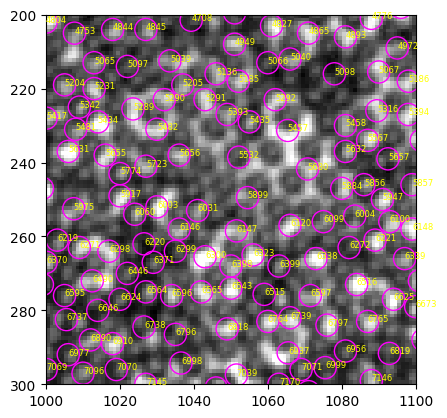

In [73]:
b_circ = [plt.Circle((xi, yi), radius=3, linewidth=1, fill=False, ec="magenta") for xi, yi in zip(particles.x, particles.y)]
b = PatchCollection(b_circ, match_original=True)
left, right, bottom, top = 1000, 1100, 300, 200
fig, ax = plt.subplots(dpi=100)
ax.imshow(img[top:bottom, left:right], cmap="gray", extent=(left, right, bottom, top))
ax.add_collection(b)
for num, i in particles.iterrows():
    ax.annotate(int(i["label"]), (i.x, i.y), xycoords="data", color="yellow", fontsize=6)

### 3.2 Gaussian mask

I have tried various shape and sigma for Mexican hat mask, but none of them work well for this image. Is there a better mask for this purpose? Gaussian mask might be the answer.

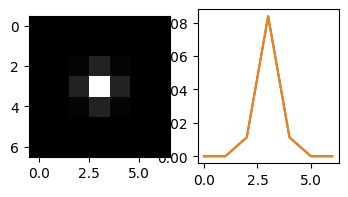

In [86]:
gs = matlab_style_gauss2D(shape=(7,7), sigma=0.5)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
ax[0].imshow(gs, cmap="gray")
ax[1].plot(gs[2, :])
ax[1].plot(gs[:, 2])

In [90]:
def find_white(img, size=7, thres=None, std_thres=None, plot_hist=False):
    """
    Similar to find_black.
    """
    
    img = to8bit(img) # convert to 8-bit and saturate
    
    gs = matlab_style_gauss2D(shape=(7,7), sigma=3)
    #plt.imshow(mh, cmap="gray")

    corr = normxcorr2(gs, img, "same")
    coordinates = peak_local_max(corr, min_distance=3) 
    
    # apply min_dist criterion
    particles = pd.DataFrame({"x": coordinates.T[1], "y": coordinates.T[0]})
    # 加入corr map峰值，为后续去重合服务
    particles["peak"] = corr[particles.y, particles.x]
    # particles = min_dist_criterion(particles, size)
    
    # 计算mask内的像素值的均值和标准差
    ## Create mask with feature regions as 1
    R = size / 2.
    mask = np.zeros(img.shape)
    for num, i in particles.iterrows():
        rr, cc = draw.disk((i.y, i.x), 0.8*R) # 0.8 to avoid overlap
        mask[rr, cc] = 1

    ## generate labeled image and construct regionprops
    label_img = measure.label(mask)
    regions = measure.regionprops_table(label_img, intensity_image=img, properties=("label", "centroid", "intensity_mean", "image_intensity")) # use raw image for computing properties
    table = pd.DataFrame(regions)
    table["stdev"] = table["image_intensity"].map(np.std)
    
    ## Arbitrary lower bound here, be careful!
    intensity_lb = (table["intensity_mean"].median() + table["intensity_mean"].mean()) / 4
    table = table.loc[table["intensity_mean"]>=intensity_lb]
    
    if thres is not None and std_thres is not None:
        table = table.loc[(table["intensity_mean"] <= thres)&(table["stdev"] <= std_thres)]
    elif thres is None and std_thres is None:
        print("Threshold value(s) are missing, all detected features are returned.")        
    elif thres is not None and std_thres is None:
        print("Standard deviation threshold is not set, only apply mean intensity threshold")
        table = table.loc[table["intensity_mean"] <= thres]
    elif thres is None and std_thres is not None:
        print("Mean intensity threshold is not set, only apply standard deviation threshold")
        table = table.loc[table["stdev"] <= std_thres]
    
    if plot_hist == True:
        table.hist(column=["intensity_mean", "stdev"], bins=20)
    
    table = table.rename(columns={"centroid-0": "y", "centroid-1": "x"}).drop(columns=["image_intensity"])

    return table

In [91]:
img = io.imread("large.tif")
particles = find_white(img, size=7)

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


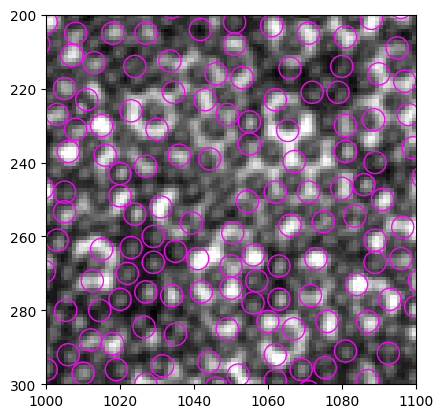

In [92]:
b_circ = [plt.Circle((xi, yi), radius=3, linewidth=1, fill=False, ec="magenta") for xi, yi in zip(particles.x, particles.y)]
b = PatchCollection(b_circ, match_original=True)
left, right, bottom, top = 1000, 1100, 300, 200
fig, ax = plt.subplots(dpi=100)
ax.imshow(img[top:bottom, left:right], cmap="gray", extent=(left, right, bottom, top))
ax.add_collection(b)

Compare with the original `find_white` result, we still don't see much improvement:

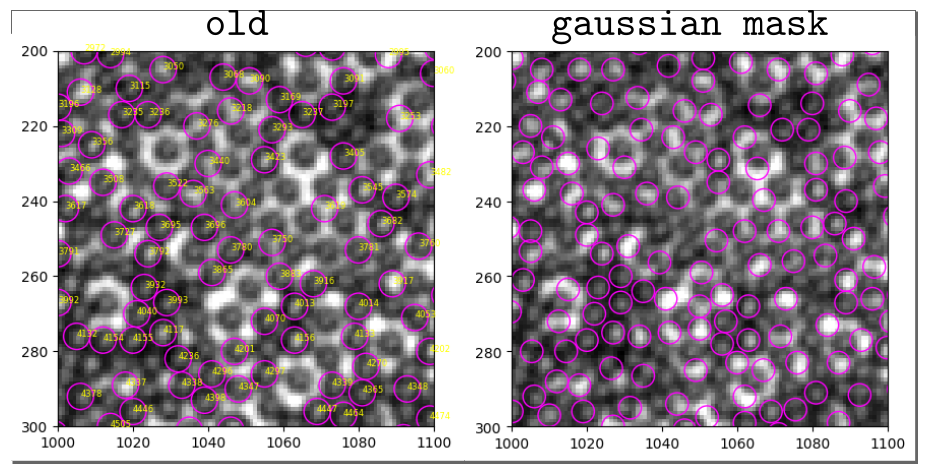

### 3.3 Double well? (I doubt if it is going to work, so I did not finish this section.)

It might help to use a mask based on the double well function:
$$
f(x) = \frac{1}{4} x^4 - \frac{1}{2} x^2
$$
the derivative of $f(x)$ is 
$$
f'(x) = x^3 - x = x(x+1)(x-1)
$$
and immediately see that $x=-1, 0, 1$ are the local extrema in this function. Let's plot $f(x)$ below:

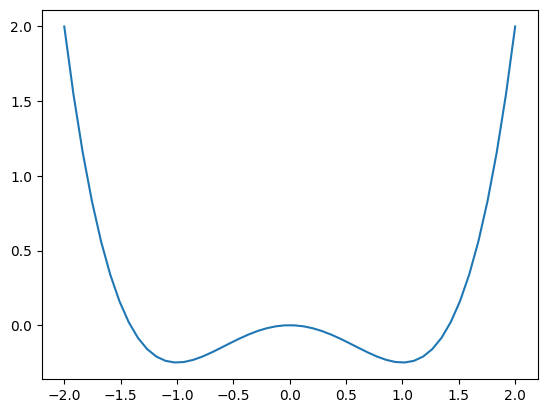

In [64]:
x = np.linspace(-2, 2)
y = x ** 4 / 4 - x ** 2 / 2
plt.plot(x, y)

## 4 Try `find_black`

Since we only have white particles in this image, they are actually the black ones compared to the background false positive. Let's try `find_black`, see if it works better.

In [93]:
img = io.imread("large.tif")
particles = find_black(img, size=7)

Threshold value(s) are missing, all detected features are returned.


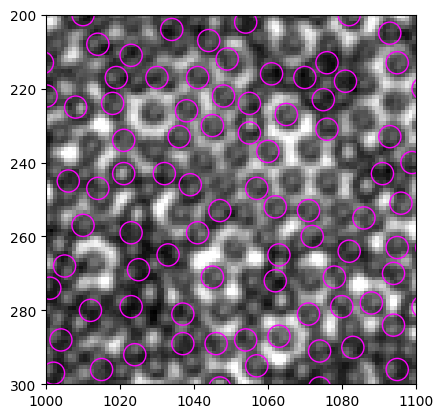

In [94]:
b_circ = [plt.Circle((xi, yi), radius=3, linewidth=1, fill=False, ec="magenta") for xi, yi in zip(particles.x, particles.y)]
b = PatchCollection(b_circ, match_original=True)
left, right, bottom, top = 1000, 1100, 300, 200
fig, ax = plt.subplots(dpi=100)
ax.imshow(img[top:bottom, left:right], cmap="gray", extent=(left, right, bottom, top))
ax.add_collection(b)

Compare with the results of `find_white`:

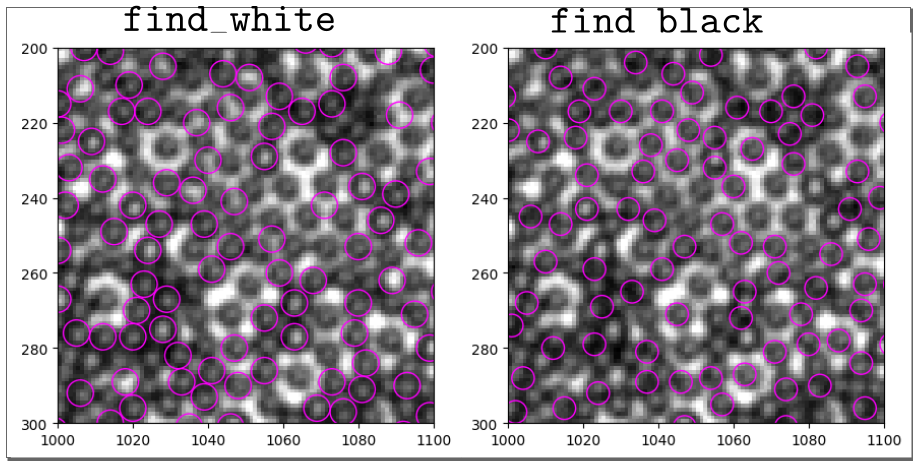

It start to be interesting! Both methods detects part of the particles, but neither out performs the other. 

There are several difficult things in this tracking task:

- the image resolution is low, only a few tens of pixels can be used to determine if a pattern is a particle or not
- the aggregation significantly changes how the particles appear in the images, they are darker in aggregates, in particular the edges.
- when particles are dense, the void spaces also look like particles because they also have bright centers and dark edges (which are actually particle edges, but of other real particles). But I think these false positives can be easily removed by thresholding the mean intensity.